**Input**
- PLINK2 GWAS summary statistics
- MAGMA gene analysis results

**Source**
- From Pan-UKBB summary statistics
- From my own GWAS

Both are based on the same data, and therefore must yield the same result

**Phenotype**  
1180 Morning/evening person (chronotype)

**Population**
- Pan-UKBB: EUR (European)
- My own GWAS: White-British

**Process: calculate the following**
- PLINK2
  - Scatter plot of SNP-wise comparison (between Pan-UKBB and my own GWAS)
    - All SNPs
    - Statistically significant SNPs
- MAGMA
  - Adding info
    - Bonferroni-corrected P-values (also written P-Bonf)
    - q-values (also known as FDR-adjusted p-values)
    - Annotation of whether those values are under FDR threshold
  - Scatter plot of SNP-wise comparison (between Pan-UKBB and my own GWAS)
    - All SNPs
    - Statistically significant SNPs

# Preparation (Execute all in this section!)

## Import libraries & set environment variables

In [2]:
import collections
from datetime import datetime
import os
import numpy as np
from pathlib import Path
import polars as pl
import re
import textwrap

import warnings
# suppress DeprecationWarning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)

from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

dir_home = Path(os.getcwd()).parent.parent.parent
os.chdir(dir_home)
print("Current directory (check that it's your home directory):", os.getcwd())

Current directory (check that it's your home directory): J:\sugai\UKBiobank


## File I/O

In [3]:
# Input: MAGMA result from Pan-UKBB
FILE_MAGMA_PANUKBB = os.path.join("analysis", 
                                   "panukbb_magma",
                                   "continuous-1180-both_sexes",
                                   "out.with_gene_name.txt")

# Input: MAGMA result from my own GWAS
FILE_MAGMA_MYGWAS = os.path.join("analysis", 
                                  "specific",
                                  "analysis_20230529_01_gwas",
                                  "00901_1180-0.0",
                                  "magma",
                                  "out.with_gene_name.txt")

# Input: PLINK result from my own GWAS
FILE_SUMSTAT_MYGWAS = os.path.join("analysis", 
                                  "specific",
                                  "analysis_20230529_01_gwas",
                                  "00901_1180-0.0",
                                  "pval_for_magma.txt")

# Input: Pan-UKBB summary statistics
FILE_SUMSTAT_PANUKBB = os.path.join("data", 
                                    "panukbb",
                                    "for_magma",
                                    "per_phenotype",
                                    "continuous-1180-both_sexes.tsv"
                                   )

# Input: my old result
FILE_SUMSTAT_MYGWAS_OLD = os.path.join("analysis", "specific", 
                                       "analysis_20230526_01_gwas",
                                       "00901_1180-0.0",
                                       "pval_for_magma.txt")

# Input: my old result
FILE_ANNOTATED_MYGWAS_OLD = os.path.join("analysis", "specific", 
                                         "analysis_20230526_01_gwas",
                                         "00901_1180-0.0", "magma",
                                         "with_p_correction.csv")


# Output folder
DIR_OUT = os.path.join("analysis", "specific", 
                       "analysis_20230529_01_gwas",
                       "summary", "1180_comparison_MyGWAS_PanUKBB")
if not os.path.exists(DIR_OUT):
    os.makedirs(DIR_OUT)

# Intermediate output: added info
#     (q-values and statistically significant genes)
FILE_ANNOTATED_PANUKBB = os.path.join(DIR_OUT, "out.with_p_correction_PanUKBB.csv")
FILE_ANNOTATED_MYGWAS = os.path.join(DIR_OUT, "out.with_p_correction_myGWAS.csv")


FDR_THRESHOLD = 0.05 # Q value threshold

## Functions

In [17]:
def flatten(l):
    for el in l:
        if isinstance(el, collections.abc.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el


def func_print(i):
    if i < 10 or str(i)[1:].count('0') == len(str(i))-1:
        now = datetime.now()
        print(f"{now.strftime('%Y-%m-%d %H:%M:%S')}: {i}")
        

def func_process(FILE_SOURCE, FILE_OUTPUT):
    # Read as String to avoid any automatic conversion
    df = (pl.read_csv(FILE_SOURCE, 
                      separator=" ", 
                      infer_schema_length=0)
          .with_columns(pl.col("P").cast(pl.Float32).alias("P_Bonf"))
          .with_columns(pl.col("P").cast(pl.Float32).alias("P_log10"))
          .with_columns(pl.col("P").cast(pl.Float32).alias("Q"))
          .with_columns(np.log10(pl.col("P_log10")))
          .sort(by='Q'))

    n_count = df['Q'].is_not_null().sum()

    df = (df
          # Calculate Bonferroni-corrected P values
          .with_columns(pl.col('P_Bonf') * n_count)
           # create a new column which is true if "P_Bonf" is under threshold
          .with_columns((pl.col("P_Bonf") < FDR_THRESHOLD).alias("Positive_P_Bonf"))
          # Calculate Q values
          # Multiply Q column by number of non-null values
          .with_columns(pl.col('Q') * n_count)
          # # Divide the Q columns by the rank of individual value among all the non-null values
          .with_columns(pl.col('Q') / df['Q'].rank())
          # create a new column which is true if "q" is under threshold
          .with_columns((pl.col("Q") < FDR_THRESHOLD).alias("Positive_Q"))
          # Add log10 values
          .with_columns(pl.col("P_Bonf").alias("P_Bonf_log10"))
          .with_columns(np.log10(pl.col("P_Bonf_log10")))
          .with_columns(pl.col("Q").alias("Q_log10"))
          .with_columns(np.log10(pl.col("Q_log10")))
          # Sort
          .sort(by='Positive_P_Bonf', descending=True)
         )

    df.write_csv(FILE_OUTPUT)
    
def func_list_genes(file_source):
    df_all = pl.read_csv(file_source, separator=",")
    df_positive = df_all.filter(pl.col("Positive_P_Bonf"))
    set_genes_all = set(df_all["NAME"])
    set_genes_positive = set(df_positive["NAME"])
    print("All =", len(set_genes_all), "genes, positive =", len(set_genes_positive), "genes")
    return set_genes_all, set_genes_positive


# Draw p-value scatter plot
def func_compare_pval(df_1, df_2, col_common,
                      graph_title,
                      col1, col2, label1, label2, is_log, plot_unit): 
    df_sumstat_comparison = df_1.join(df_2, on=col_common, how="inner").drop_nulls()
    
    # Scatter plot
    fig, ax = plt.subplots(figsize=[5, 5])
    x = df_sumstat_comparison[col1].to_numpy()
    y = df_sumstat_comparison[col2].to_numpy()
    if not is_log:
        x = np.log10(x)
        y = np.log10(y)

    print("Corr =", np.corrcoef(x, y)[0, 1])

    ax.scatter(x, y, s=2)
    line1, = ax.plot(np.linspace(-30, 0, 10), np.linspace(-30, 0, 10),
                    linestyle="dashed", color = "crimson", alpha = 0.5,)

    ax.set_xlim(-plot_unit * 3, 0)
    ax.set_ylim(-plot_unit * 3, 0)
    ax.set_xticks([-plot_unit * 3, -plot_unit * 2, -plot_unit, 0]) 
    ax.set_yticks([-plot_unit * 3, -plot_unit * 2, -plot_unit, 0]) 

    ax.set_xlabel(label1, fontsize=20)
    ax.set_ylabel(label2, fontsize=20)
    ax.set_title(graph_title, fontsize=24)
    plt.show()
    
    data1 = df_1[col1].to_numpy()
    data2 = df_2[col2].to_numpy()
    if not is_log:
        data1 = np.log10(data1)
        data2 = np.log10(data2)

    # Histogram for each
    fig, ax = plt.subplots(figsize=[5, 5])
    ax.set_xlabel(graph_title, fontsize=22)
    ax.set_ylabel("Count", fontsize=24)
    ax.set_yscale('log')
    ax.hist(data2, # different from y: the whole data
            alpha=0.5, label=label2, density=False, bins=100, color="green")
    ax.hist(data1, # different from x: the whole data
            alpha=1, label=label1, density=False, bins=100, color='#f48d63')
    ax.legend(fontsize=20)

    plt.show()
    
# Draw Venn diagrams - 2 sets
def func_venn2(set_genes_1, set_genes_2, list_names):
    plt.rcParams["figure.figsize"] = [3.5, 3.5]
    plt.rcParams["figure.autolayout"] = True

    out = venn2(
        [set_genes_1, set_genes_2], 
          list_names
               )
    
    for text in out.set_labels:
        text.set_fontsize(14)
    try: # Sometimes it fails because no intersect exists
        for text in out.subset_labels:
            text.set_fontsize(12)
    except:
        pass
    plt.show()

# Process summary statistics

In [10]:
df_sumstat_mygwas = (pl.read_csv(FILE_SUMSTAT_MYGWAS, 
                                 separator=" ", 
                                 infer_schema_length=0)
                     .with_columns(pl.col("P").cast(pl.Float64))
                     .rename({"P": "P_MyGWAS"})
     )

df_sumstat_mygwas_old = (pl.read_csv(FILE_SUMSTAT_MYGWAS_OLD, 
                                 separator=" ", 
                                 infer_schema_length=0)
                     .with_columns(pl.col("P").cast(pl.Float64))
                     .rename({"P": "P_MyGWAS_old"})
     )

df_sumstat_panukbb = (pl.read_csv(FILE_SUMSTAT_PANUKBB, 
                                  separator=" ", 
                                  infer_schema_length=0)
                      .with_columns(pl.col("P").cast(pl.Float64))
                      .rename({"P": "P_PanUKBB"})
     )

In [11]:
print(df_sumstat_mygwas.head)
print(df_sumstat_mygwas_old.head)
print(df_sumstat_panukbb.head)

<bound method DataFrame.head of shape: (28_037_468, 2)
┌─────────────────────┬────────────┐
│ SNP                 ┆ P_MyGWAS   │
│ ---                 ┆ ---        │
│ str                 ┆ f64        │
╞═════════════════════╪════════════╡
│ 1:182573227[b37]T,C ┆ 3.4359e-17 │
│ 1:182569626[b37]T,C ┆ 4.1132e-17 │
│ 1:182553693[b37]C,T ┆ 5.4056e-17 │
│ 1:182558139[b37]G,T ┆ 5.5977e-17 │
│ …                   ┆ …          │
│ 11:66517241[b37]C,T ┆ 1.0        │
│ 7:22069532[b37]G,A  ┆ 1.0        │
│ 18:33429378[b37]G,C ┆ 1.0        │
│ 17:66542950[b37]G,A ┆ 1.0        │
└─────────────────────┴────────────┘>
<bound method DataFrame.head of shape: (9_437_885, 2)
┌─────────────────────┬──────────────┐
│ SNP                 ┆ P_MyGWAS_old │
│ ---                 ┆ ---          │
│ str                 ┆ f64          │
╞═════════════════════╪══════════════╡
│ 1:182573227[b37]T,C ┆ 3.4122e-17   │
│ 1:182569626[b37]T,C ┆ 4.0844e-17   │
│ 1:182553693[b37]C,T ┆ 5.3722e-17   │
│ 1:182558139[b37]G,T ┆

## Compare P-values

Corr = 0.4258956482200447


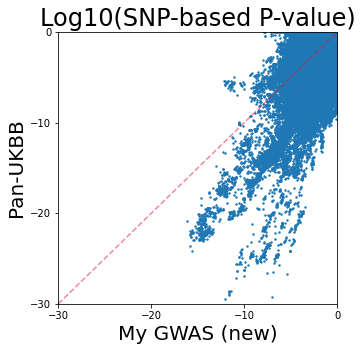

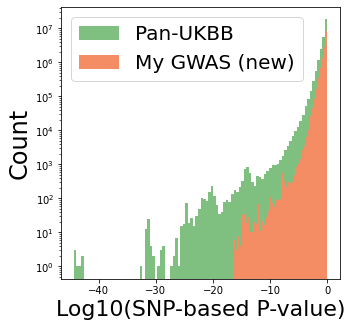

Corr = 0.5567517273136411


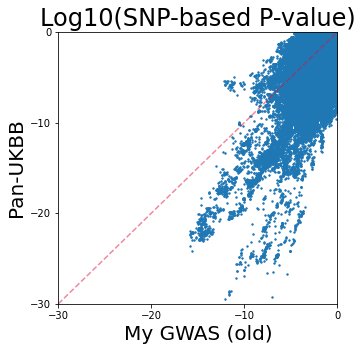

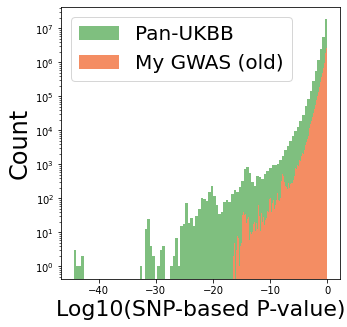

Corr = 0.9999951926309644


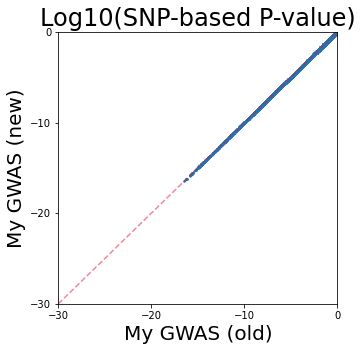

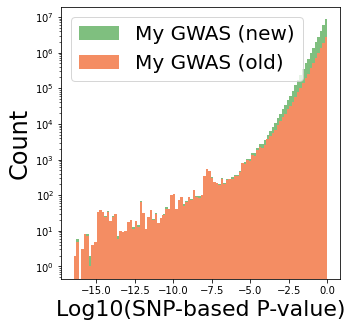

In [16]:
func_compare_pval(df_sumstat_mygwas, df_sumstat_panukbb, "SNP",
                  "P_MyGWAS", "P_PanUKBB",
                  "My GWAS (new)", "Pan-UKBB",
                  False, 10
                 )

func_compare_pval(df_sumstat_mygwas_old, df_sumstat_panukbb, "SNP",
                  "P_MyGWAS_old", "P_PanUKBB",
                  "My GWAS (old)", "Pan-UKBB",
                  False, 10
                 )

func_compare_pval(df_sumstat_mygwas_old, df_sumstat_mygwas, "SNP",
                  "P_MyGWAS_old", "P_MyGWAS",
                  "My GWAS (old)", "My GWAS (new)",
                  False, 10
                 )

# Process MAGMA results

## Add Pbonf, q-values, posi/nega annotation

In [9]:
func_process(FILE_MAGMA_MYGWAS, FILE_ANNOTATED_MYGWAS)
func_process(FILE_MAGMA_PANUKBB, FILE_ANNOTATED_PANUKBB)

## List up the genes

In [20]:
print("My GWAS (new)")
set_genes_all_mygwas, set_genes_positive_mygwas = \
func_list_genes(FILE_ANNOTATED_MYGWAS)
print()

print("My GWAS (old)")
set_genes_all_mygwas_old, set_genes_positive_mygwas_old = \
func_list_genes(FILE_ANNOTATED_MYGWAS_OLD)
print()

print("Pan-UKBB")
set_genes_all_panukbb, set_genes_positive_panukbb = \
func_list_genes(FILE_ANNOTATED_PANUKBB)

My GWAS (new)
All = 19427 genes, positive = 35 genes

My GWAS (old)
All = 16588 genes, positive = 34 genes

Pan-UKBB
All = 19427 genes, positive = 270 genes


## Draw Venn diagrams

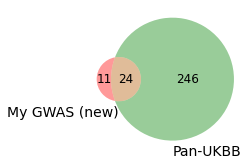

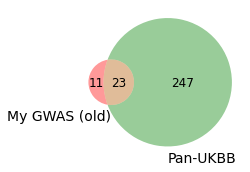

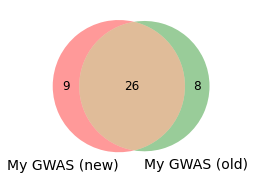

In [21]:
func_venn2(set_genes_positive_mygwas, set_genes_positive_panukbb, ["My GWAS (new)", "Pan-UKBB"])
func_venn2(set_genes_positive_mygwas_old, set_genes_positive_panukbb, ["My GWAS (old)", "Pan-UKBB"])
func_venn2(set_genes_positive_mygwas, set_genes_positive_mygwas_old, ["My GWAS (new)", "My GWAS (old)"])

In [23]:
print("Only in old", set_genes_positive_mygwas_old - set_genes_positive_mygwas)
print()

print("Only in new", set_genes_positive_mygwas - set_genes_positive_mygwas_old)

Only in old {'SPTBN2', 'ZMYND10', 'IFRD2', 'LSMEM2', 'HYAL1', 'C11orf80', 'LRFN4', 'SPATA7'}

Only in new {'AP2B1', 'CLIP1', 'C18orf42', 'ASB1', 'ZNF365', 'LRRTM4', 'FUT1', 'EXOC4', 'MMP16'}


## Compare P-values

In [6]:
df_genebased_mygwas = pl.read_csv(FILE_ANNOTATED_MYGWAS, separator=",")
df_genebased_mygwas_old = pl.read_csv(FILE_ANNOTATED_MYGWAS_OLD, separator=",")
df_genebased_panukbb = pl.read_csv(FILE_ANNOTATED_PANUKBB, separator=",")

# Extract columns "NAME" and "P"
df_genebased_mygwas = (df_genebased_mygwas
                       .select(["NAME", "P_log10"]).rename({"P_log10": "Log10P_mygwas"})
                      )

df_genebased_mygwas_old = (df_genebased_mygwas_old
                           .select(["NAME", "P_log10"]).rename({"P_log10": "Log10P_mygwas_old"})
                          )

df_genebased_panukbb = (df_genebased_panukbb
                        .select(["NAME", "P_log10"]).rename({"P_log10": "Log10P_panukbb"})
                       )

In [7]:
print(df_genebased_mygwas.head)
print(df_genebased_mygwas_old.head)
print(df_genebased_panukbb.head)

<bound method DataFrame.head of shape: (19_427, 2)
┌──────────────┬───────────────┐
│ NAME         ┆ Log10P_mygwas │
│ ---          ┆ ---           │
│ str          ┆ f64           │
╞══════════════╪═══════════════╡
│ CPNE8        ┆ -13.923286    │
│ RGS16        ┆ -13.55233     │
│ ALG10B       ┆ -13.15871     │
│ RNASEL       ┆ -10.987037    │
│ …            ┆ …             │
│ LOC100129520 ┆ null          │
│ CXorf51A     ┆ null          │
│ ZBTB33       ┆ null          │
│ GAGE12F      ┆ null          │
└──────────────┴───────────────┘>
<bound method DataFrame.head of shape: (16_588, 2)
┌──────────┬───────────────────┐
│ NAME     ┆ Log10P_mygwas_old │
│ ---      ┆ ---               │
│ str      ┆ f64               │
╞══════════╪═══════════════════╡
│ ALG10B   ┆ -14.71155         │
│ RGS16    ┆ -14.632364        │
│ CPNE8    ┆ -13.460435        │
│ C11orf80 ┆ -11.183089        │
│ …        ┆ …                 │
│ G3BP1    ┆ -0.000161         │
│ SAG      ┆ -0.000152         │
│ ANKR

Corr = 0.5475640916270716


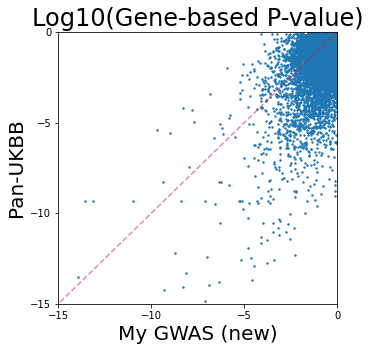

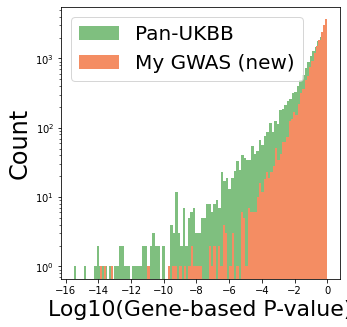

Corr = 0.603304506891683


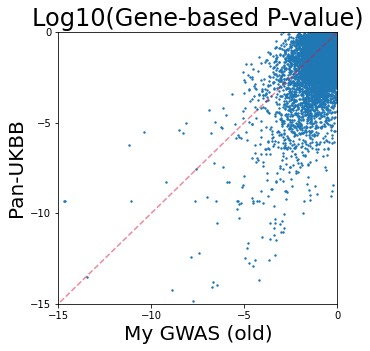

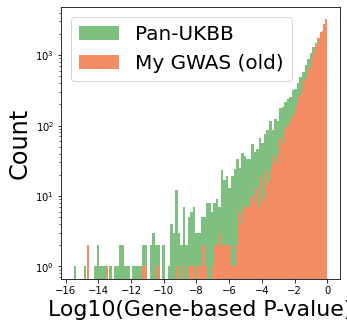

Corr = 0.8909712070905957


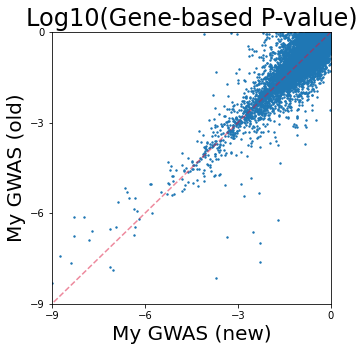

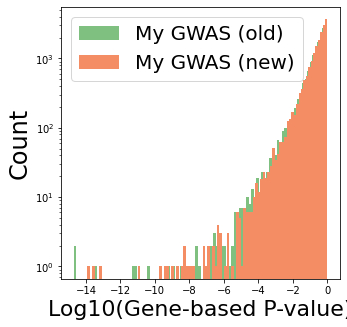

In [18]:
func_compare_pval(df_genebased_mygwas, df_genebased_panukbb, "NAME",
                  "Log10(Gene-based P-value)",
                  "Log10P_mygwas", "Log10P_panukbb",
                  "My GWAS (new)", "Pan-UKBB",
                  True, 5
                 )

func_compare_pval(df_genebased_mygwas_old, df_genebased_panukbb, "NAME",
                  "Log10(Gene-based P-value)",
                  "Log10P_mygwas_old", "Log10P_panukbb",
                  "My GWAS (old)", "Pan-UKBB",
                  True, 5
                 )

func_compare_pval(df_genebased_mygwas, df_genebased_mygwas_old, "NAME",
                  "Log10(Gene-based P-value)",
                  "Log10P_mygwas", "Log10P_mygwas_old",
                  "My GWAS (new)", "My GWAS (old)",
                  True, 3
                 )